In [1]:
import cugraph
import cudf

import numpy as np
import math
import os
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.optimize import bisect
from collections import Counter
from scipy.stats import t

In [2]:
file = 'matrices_filtradas/cvv-0.50-mdS01.txt'

In [3]:
file_name = file.split(os.sep)[-1].split('-')[-1].split('.')[0]

df = cudf.read_csv(
    filepath_or_buffer=file,
    header=None,
    names=['Source', 'Target', 'Weight'],
    sep=' ')

df[0:10]

,Source,Target,Weight
0,9945,13724,0.613
1,9945,13848,0.530
2,9945,13850,0.529
3,9945,25507,0.530
4,9945,25633,0.506
5,9945,25634,0.508
6,9945,29604,0.513
7,9945,29605,0.543
8,9945,29731,0.533
9,9945,29854,0.587


In [4]:
#percentages = [5 * (20 - i) for i in range(1, 20)] # [5, 95]
percentages = [5 * (10 - i) for i in range(1, 10)] # [5, 50]

percentages

[45, 40, 35, 30, 25, 20, 15, 10, 5]

In [5]:
fields = []

list_weights = df['Weight'].drop_duplicates().to_arrow().to_pylist()
nodes_weight = cudf.concat([
    df[['Source', 'Weight']].rename(columns={"Source": "Vertex", "Weight": "Weight"}),
    df[['Target', 'Weight']].rename(columns={"Target": "Vertex", "Weight": "Weight"})
                            ])
node_list = nodes_weight['Vertex'].drop_duplicates().to_arrow().to_pylist()


for weight in tqdm(list_weights):
  n = len(nodes_weight[nodes_weight['Weight'] >= weight])
  fields.append({
            'Weight': weight,
            'N': n,
            'n%': (n / len(nodes_weight)) * 100
        })


df_percentages = cudf.DataFrame(fields).sort_values(by='n%', ascending=False)
weight_df = cudf.DataFrame()
closest_percentage = []

for percentage in percentages:
    val_list = np.abs(df_percentages['n%'] - percentage).to_arrow().to_pylist()
    val_index = val_list.index(
        min(val_list)
    )
    value = float(df_percentages['n%'].values[val_index])
    weight_df = cudf.concat([
                       weight_df,
                       df_percentages[df_percentages['n%'] == value]

    ])
    for i in range(df_percentages[df_percentages['n%'] == value].shape[0]):
        closest_percentage.append(percentage)

weight_df['closest_n%'] = closest_percentage

weight_df

  0%|          | 0/481 [00:00<?, ?it/s]

,Weight,N,n%,closest_n%
125,0.625,22422,44.982546,45
139,0.639,19968,40.059383,40
155,0.655,17368,34.843317,35
172,0.672,14908,29.908117,30
192,0.692,12402,24.880632,25
216,0.716,9934,19.929382,20
246,0.746,7440,14.925972,15
285,0.785,4956,9.942623,10
343,0.843,2504,5.023472,5


In [6]:
def frequencies(df):
    a = df.value_counts(subset=['Vertex'])
    hitcount = cudf.DataFrame({'Vertex' : a.index.to_arrow()[0].to_pylist(), 'degree': a.values})
    c = Counter(hitcount['degree'].to_arrow().to_pylist())
    return cudf.DataFrame({
            'Grado': c.keys(),
            'Recuento': c.values()
            }).sort_values(by='Grado')

In [7]:
def get_gamma(df):
    
    if df.empty:
        return np.NaN

    x = df['Grado'].to_numpy()
    y = df['Recuento'].to_numpy()

    if len(x) < 10:
        return np.NaN

    try:
        def f(gamma):

            s_xx = sum(x ** (-2 * gamma))
            s_xy = sum(y * (x ** -gamma))

            s_lxy = sum(y * np.log(x) * (x ** -gamma))
            s_lxx = sum(np.log(x) * (x ** (-2 * gamma)))
            return s_lxy - (s_xy / s_xx) * s_lxx

        a = 0
        b = 10

        return bisect(f, a, b)

    except: f'Error while obtaining gamma value'

    # EL ajuste interesante es pasar los datos a coordenada doble logaritmica -> para ajustar los datos a una recta

In [8]:
def get_beta(df, gamma):
    
    if df.empty or gamma is None:
        return np.NaN
    
    x = df['Grado'].to_numpy()
    y = df['Recuento'].to_numpy()
    
    
    s_xx = sum(x ** (-2 * gamma))
    s_xy = sum(y * (x ** -gamma))
    
    return np.log(s_xy/s_xx)

In [9]:
def mse_regression(df):
        
    x = np.log(df['Grado'].to_numpy())
    y = np.log(df['Recuento'].to_numpy())
    
    gamma = get_gamma(df)
    beta = get_beta(df, gamma)
    
    if gamma is None:
        return np.NaN, np.NaN, np.NaN, np.NaN
    
    # R-squared    
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    
    ss_u = np.sum((x-x_bar)*(y-y_bar))
    ss_l = np.sqrt(np.sum((x-x_bar)**2)*np.sum((y-y_bar)**2))
    
    r_squared = ss_u/ss_l
    
    n = len(y)
    t_value = np.sqrt(r_squared*(n - 2))/np.sqrt(1 - r_squared)
    p_value = t.pdf(t_value, n-2)

    
    return gamma, beta, r_squared, p_value

In [10]:
def plot_by_percentages():
    
    print('##### BEGING THE PROCESS OF PLOTTING FREQUENCY DISTRIBUTIONS USING DIFFERENT THRESHOLDS ########')
    
    freq = frequencies(nodes_weight)
    fig = plt.figure()
    ax = plt.gca()
    ax.loglog(freq['Grado'].to_numpy(), freq['Recuento'].to_numpy(), '.')
    
    max_x = max(freq['Grado'].to_numpy())
    max_y = max(freq['Recuento'].to_numpy())
    print(max_x)
    
    plt.title(f'100% - Weight threshold: {min(list_weights):.3f}')
    ax.set_xlabel('Recuento - k')
    ax.set_ylabel('Grado - P(k)')
    plt.show()
    
    gamma, beta, r_squared, p_value = mse_regression(freq)
    print(f'Gamma: {gamma:.4f}, Beta:{beta:.4f}, R^2:{r_squared:.4f} \n')    
    
    if weight_df.empty:
        return cudf.DataFrame()

    for percentage in percentages:
        
        weight = weight_df[weight_df['closest_n%'] == percentage]['Weight'].to_numpy()[0]
        nodes = nodes_weight[nodes_weight['Weight'] >= weight]

        freq = frequencies(nodes_weight[nodes_weight['Weight'] >= weight])
        fig = plt.figure()
        ax = plt.gca()
        ax.scatter(freq['Grado'].to_numpy(), freq['Recuento'].to_numpy(), s=5)
        ax.set_yscale('log')
        ax.set_xscale('log')
        

        
        gamma, beta, r_squared, p_value = mse_regression(freq)
        
        if np.abs(r_squared) > 0.9:
            ax.plot(np.asarray([10 ** i for i in range(0, math.ceil(np.log10(max_x)))]),
                    np.exp(beta)*(np.asarray([10 ** i for i in range(0, math.ceil(np.log10(max_x)))])**(-gamma)),
                    'r')
        
        plt.xticks([10 ** i for i in range(0, math.ceil(np.log10(max_x)))])
        plt.yticks([10 ** i for i in range(0, math.ceil(np.log10(max_y)))])
        ax.set_xlabel('Recuento - k')
        ax.set_ylabel('Grado - P(k)')
        
        plt.title(f'{percentage}% - Weight threshold: {weight:.3f}')
        if np.abs(r_squared) > 0.9:
                plt.savefig(f'images/{file_name}-{weight:.3f}.png')
        plt.show()
        
        print(f'Gamma: {gamma:.4f}, Beta:{beta:.4f}, R^2:{r_squared:.4f} \n')

##### BEGING THE PROCESS OF PLOTTING FREQUENCY DISTRIBUTIONS USING DIFFERENT THRESHOLDS ########
290


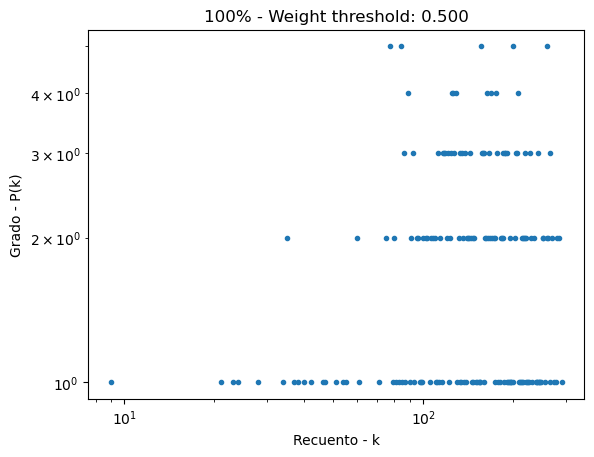

Gamma: nan, Beta:nan, R^2:nan 



/tmp/ipykernel_245/2279956203.py:22: RuntimeWarning: invalid value encountered in sqrt
  t_value = np.sqrt(r_squared*(n - 2))/np.sqrt(1 - r_squared)


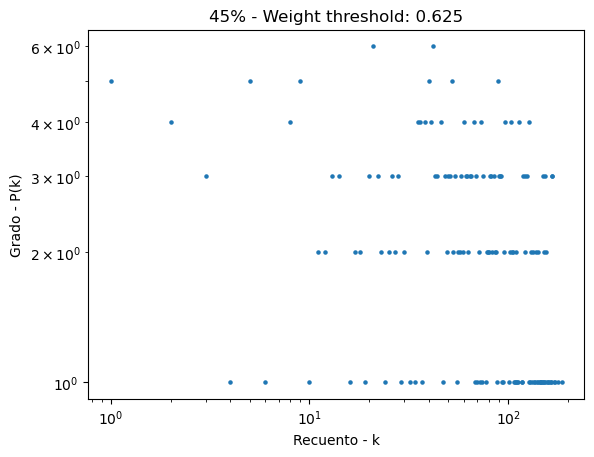

Gamma: 0.1596, Beta:1.4543, R^2:-0.3193 



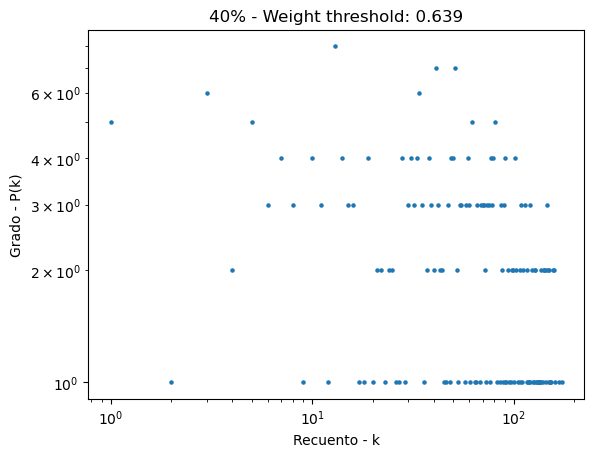

Gamma: 0.1883, Beta:1.5638, R^2:-0.3423 



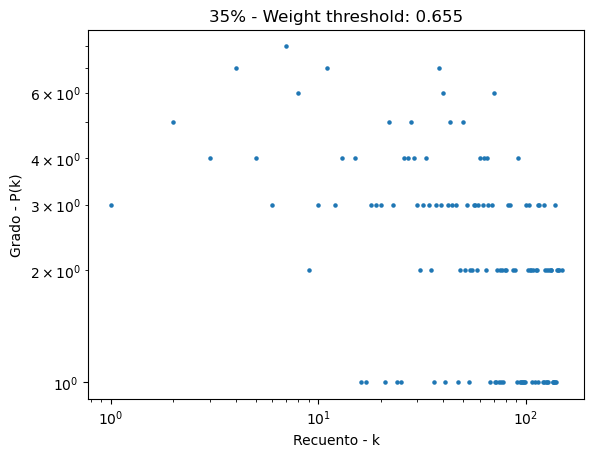

Gamma: 0.2267, Beta:1.8046, R^2:-0.4757 



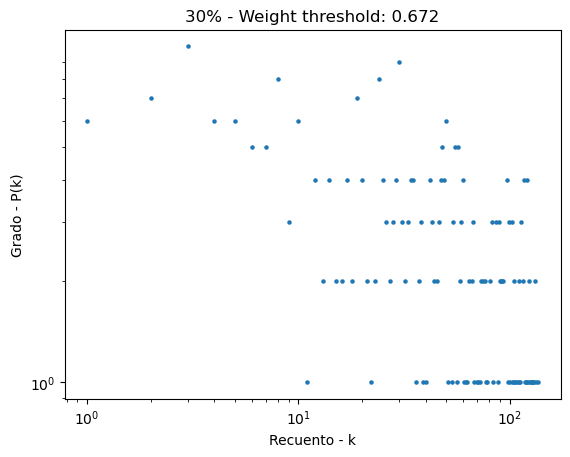

Gamma: 0.3279, Beta:2.1951, R^2:-0.5958 



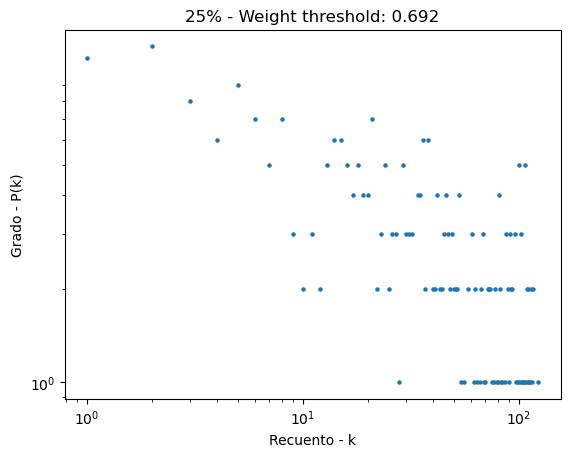

Gamma: 0.4184, Beta:2.5513, R^2:-0.7153 



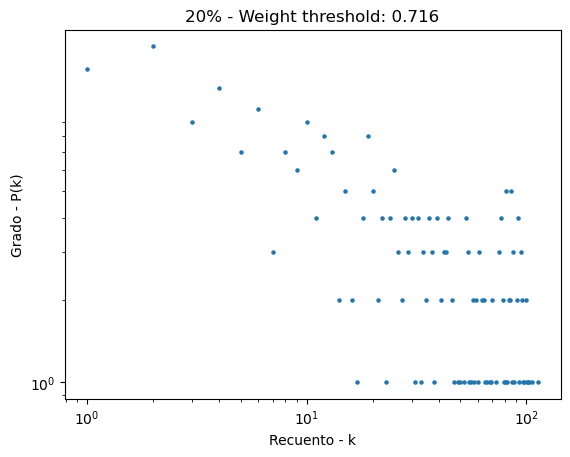

Gamma: 0.5066, Beta:2.8683, R^2:-0.7099 



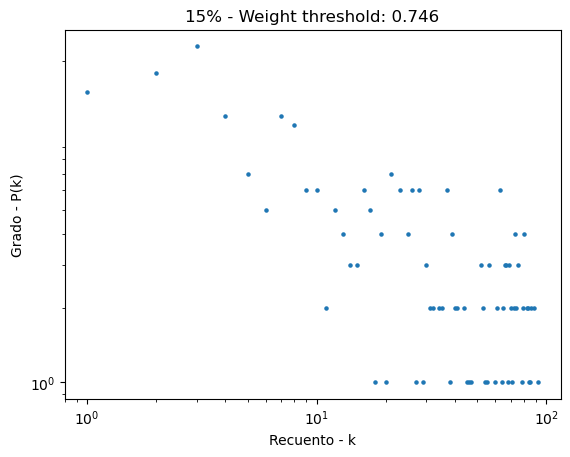

Gamma: 0.5409, Beta:3.0563, R^2:-0.7120 



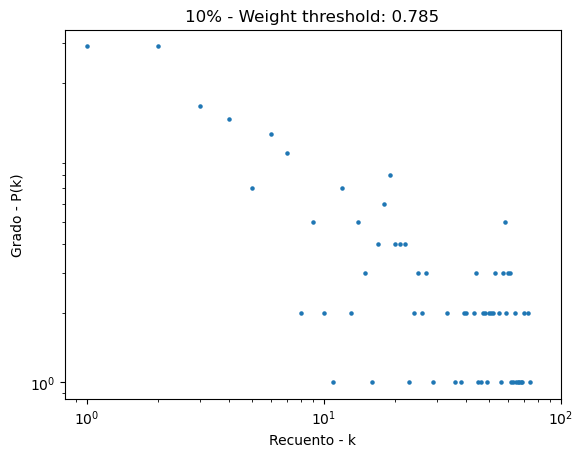

Gamma: 0.7476, Beta:3.5058, R^2:-0.7651 



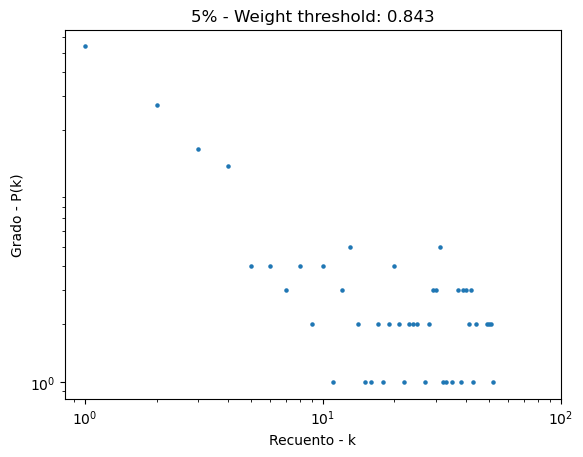

Gamma: 1.1587, Beta:3.9983, R^2:-0.7367 



In [11]:
plot_by_percentages()
# OJO: LAS DIMENSIONES FIJAS PARA COMPARAR